# CH6 循环神经网络

循环神经网络是近来使用较为广泛的一种深度学习架构。RNN的基本思想是将输入的时序类型信息纳入考虑。

RNN被证明，在文本字符预测和句子中下一个单词的预测等问题上具有非常好的性能。

## 6.1 RNN 的基本概念

与卷积神经网络不同，RNN具有**环状结构**，可以使信息得以维持。

RNN每次处理一个时序输入，更新一种向量状态(可以视为系统的一种记忆模式)，该向量含有序列中所有过去的元素。

## 6.2 RNN 的工作机制

状态向量$S_t$由当前输入和之前的状态向量通过矩阵U和W计算。

$St = f (U·X_t + W·S_{t-1})$

$f$是一个非线性函数，与tanh和ReLU类似。可以看到，函数中的两项要先求和，然后被f处理。

最后，$O_t$是网络输出，由矩阵V计算得来。

$O_t=V·S_t$

## 6.3 RNN 的展开

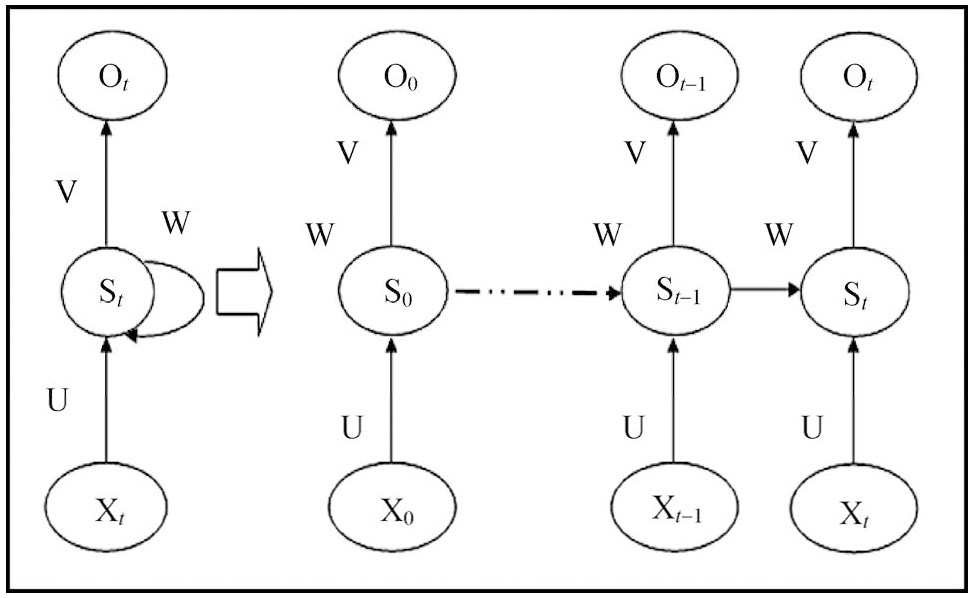

图6-2在**互异、离散时间**的整个输入序列上展开网络结构，获得RNN的一种展开形式。从图中可以清晰地看出，这种结构与典型的多层神经网络不同，因为典型的多层神经网络在每一层使用不同的参数；**而RNN在每个时刻使用的参数均相同，即U、V和W**。

的确，RNN在每个时刻、对同一序列的不同输入执行同样的运算。由于共享了相同的参数，RNN极大地减少了网络在训练过程中需要学习的参数数量，也因此缩短了网络训练时间。

从RNN的展开形式看，很显然，我们只需要对反向传播算法做一些微小的改变，就可以对这种网络进行训练。

实际上，由于参数在每个时刻都是共享的，所以计算出的梯度不仅依赖于当前运算，还与之前的运算有关。

例如，如果要计算（t = 4时刻的）梯度，必须将计算出的梯度反向传播3个时刻，然后对获得的所有梯度求和。实际上，整个输入序列一般被视为训练集的一个单个元素。因此，如果总误差是所有时刻（输入序列中的每个元素）误差的简单求和，那么总误差梯度就是每个时刻误差梯度的和。

这个过程称为**沿时间反向传播**。

## 6.4 梯度消失问题
在反向传播算法中，权重是根据梯度误差按照比例调整的。梯度的计算需要注意以下几点。
* 如果权重很小，梯度可能会“消失”，即梯度信号太小以至于学习变得很慢甚至停止。这种现象经常称为梯度消失。
* 如果矩阵中的权重过大，可能会因梯度过大而导致学习不收敛。这种现象通常称为梯度爆炸。

梯度的消失爆炸问题也会影响RNN。实际上，BPTT算法会展开RNN，使其变成一个很深的前馈神经网络。RNN网络的时序不能太长就是出于这个原因。如果梯度在数层之后开始消失或爆炸，网络就不能学习数据之间比较高的时间距离关系。

图6-3解释了该现象的组织关系。被计算并反向传播的梯度在每个时刻都趋向于减少（或增加）。在一定数量的时刻后，梯度收敛为0（或爆炸为无穷大）。

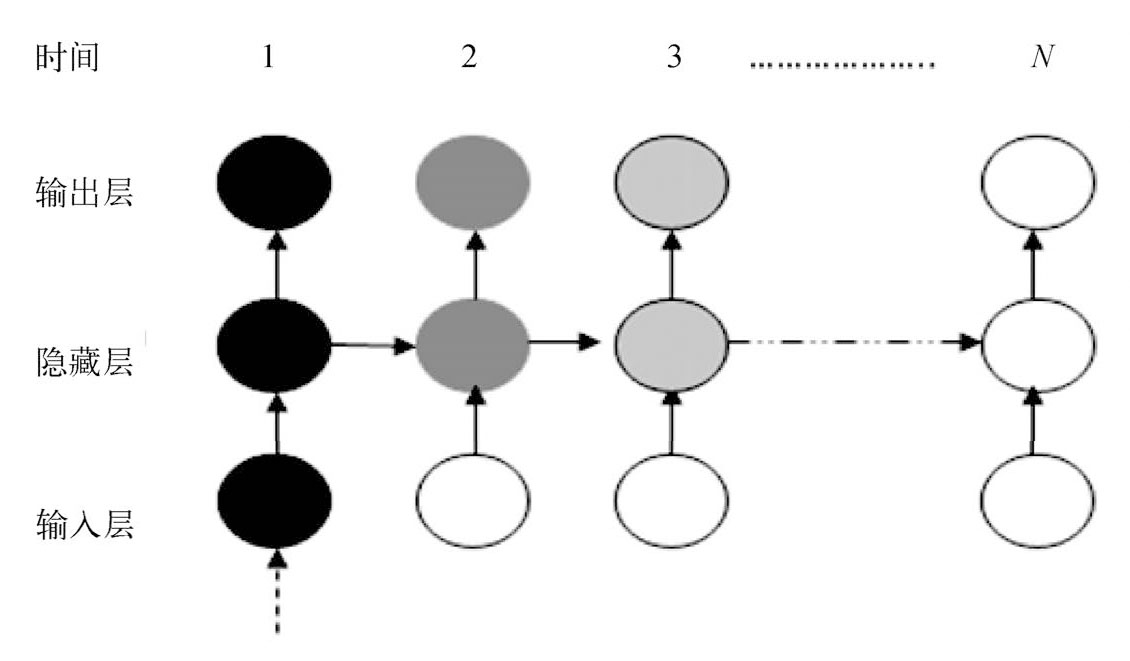

## 6.5 LSTM 网络
**长短期记忆**是一种特殊的循环神经网络架构，最早由赛普·霍克赖特和于尔根·施密德胡伯在1997年提出。这种类型的神经网络是在深度学习环境下提出的，因为它不受梯度消失问题的影响，且结果和性能非常优秀。基于LSTM的网络对于时序数据的预测和分类问题效果十分理想，正在逐渐取代传统方法，将很多问题的解决方案向深度学习发展。

LSTM网络由许多互相连接的元胞（LSTM块）组成，如图6-4所示。每个LSTM块包含三种类型的门：**输入门**、**输出门**和**遗忘门**，分别实现对元胞记忆的写、读和重置函数。这些门并不是二元的，而是模拟的。（一般由sigmoid类激活函数映射到区间[0, 1]生成，0代表全部抑制，1代表全部激活。）

这些门的存在使LSTM元胞可以记忆不确定时间的信息。实际上，下面的输入门为激活阈值，该元胞会保持前面的状态；如果当前状态被启动，那么该状态将会和输入值合并。顾名思义，遗忘门负责重置元胞当前状态（当其值被置为0），输出门决定是否将该元胞中的值输出。
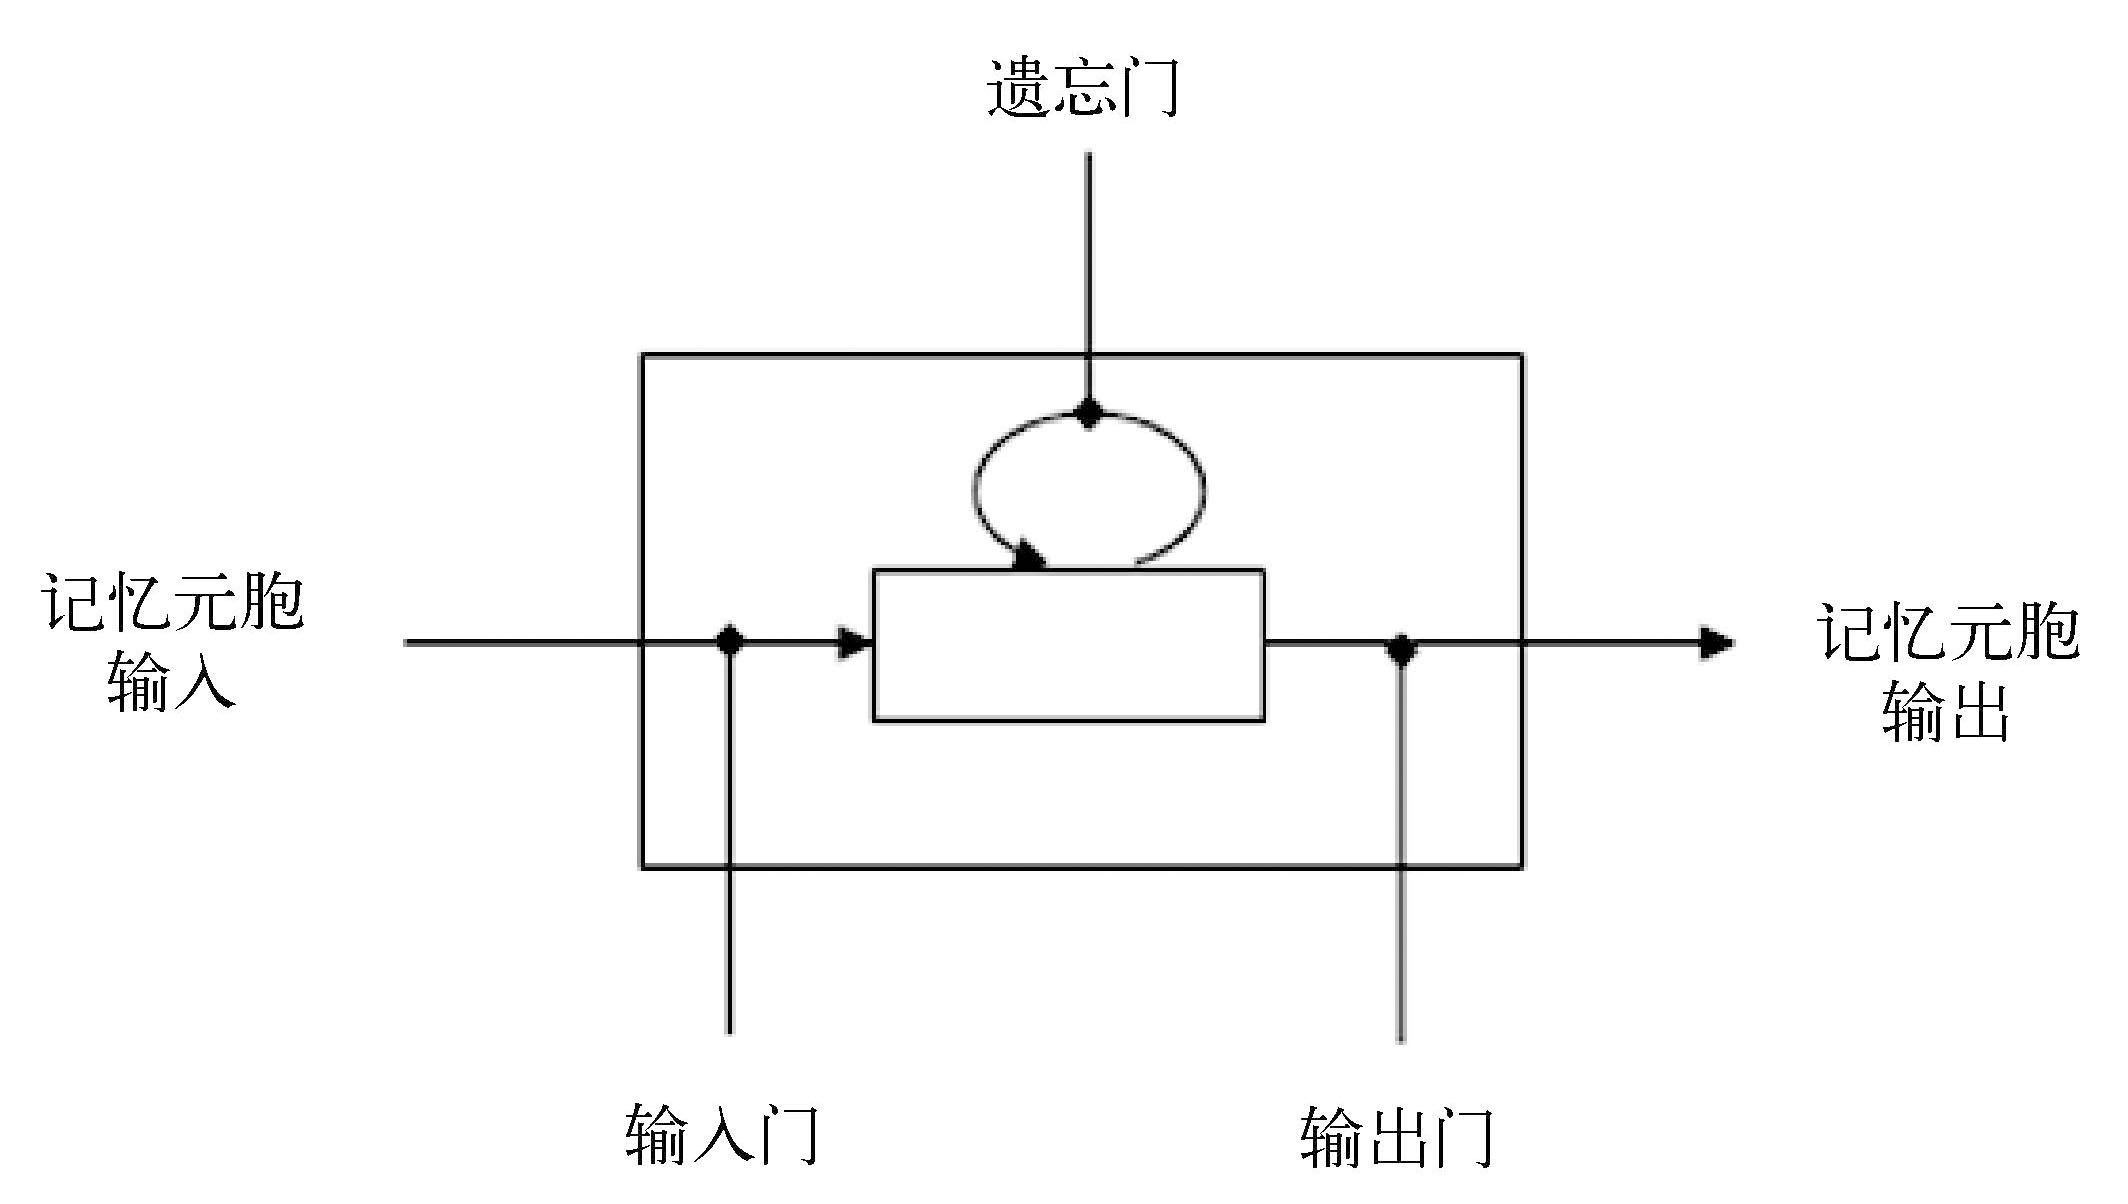

## 6.6 RNN 图像分类器
下面介绍一种包含LSTM块的图像分类循环模型实现。我们使用著名的MNIST数据集。

我们实现的模型包含一个LSTM层，紧跟一个降维求平均操作，再加一个softmax层，如图6-5所示。

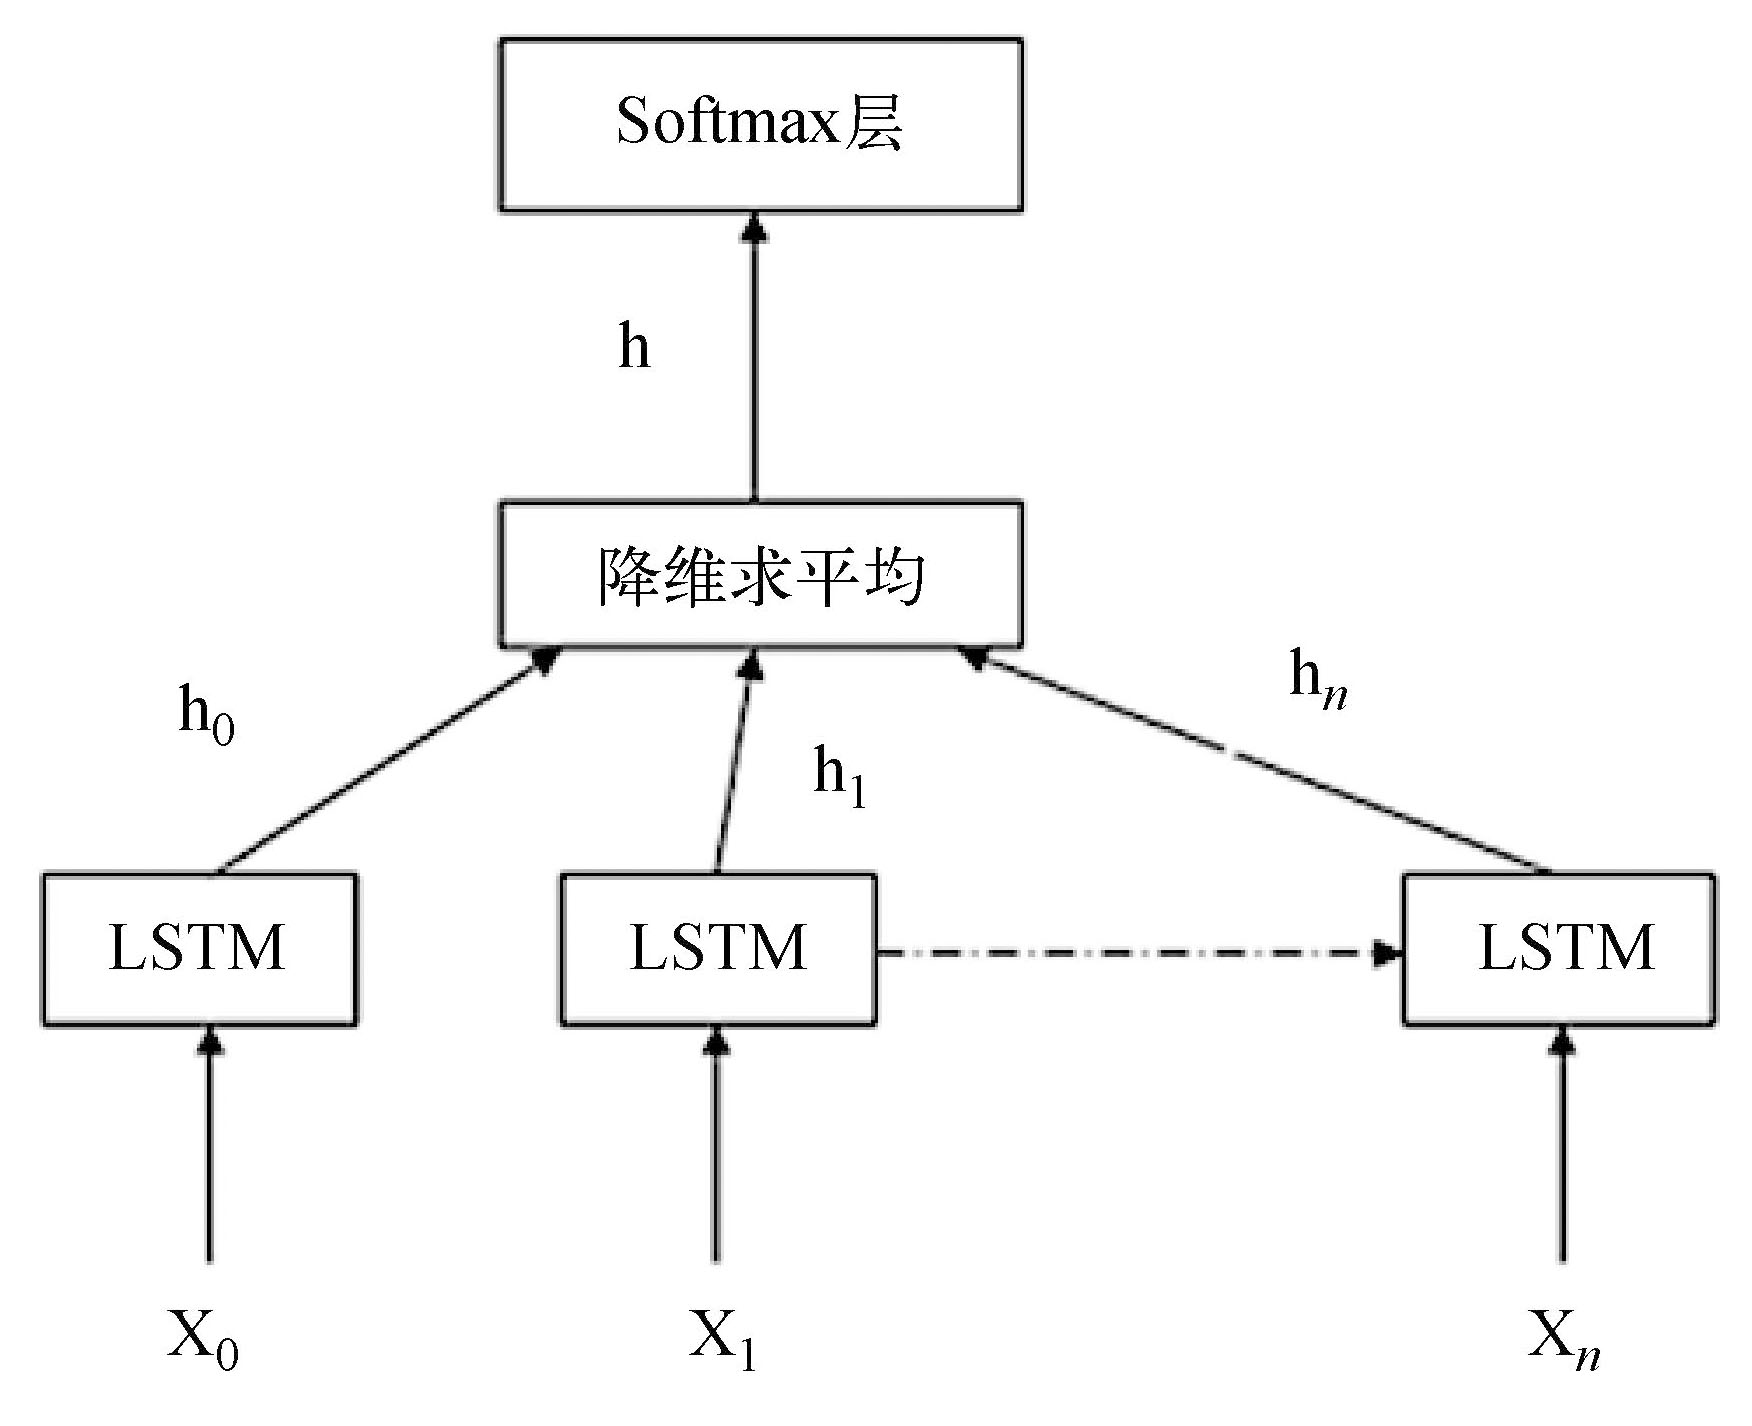

下面的代码计算了一个张量中所有维度内元素的均值，并将input_tensor沿着数轴中给定的维度降维。如果keep_dims的值不为true，张量的值会随着数轴上的每一项减1。如果keep_dim为true，那么被降低的维度会以长度1被保持。

`tf.reduce_mean(input_tensor, axis=None, keep_dims=False, name=None, reduction_indices=None)`

如果数轴中没有条目，所有维度都会被约减，然后返回一个只含有一个元素的张量。

例如：
```python
x =[[1., 1.]
    [2., 2.]]
tf.reduce_mean(x)==> 1.5
tf.reduce_mean(x,0)==> [1.5,1.5]
tf.reduce_mean(x,1)==> [1.,2.]
```

因此，如果输入序列为$x_0, x_1, …, x_n$，那么LSTM层中的记忆元胞会生成一个表示序列$h_0, h_1, …, h_n$。

这个表示序列会对所有时间步取均值，最终的输出表示为h。最后，这个表示会被馈给softmax层，其目标是将输入序列与类标签对应。

下面开始实现该模型。

In [ ]:
import tensorflow as tf
from tensorflow.contrib import rnn

导入的`rnn`和`rnn_cell`为TensorFlow类，描述如下。

`rnn_cell`模型提供了一系列常用的基本RNN元胞，如LSTM和一系列操作符，可以为输入添加dropout、映射或嵌入操作。

In [ ]:
# 然后使用下述库载入MNIST数据集：
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

In [ ]:
# 要使用循环神经网络分类图像，必须将每个图像视为一个像素序列。
# 由于MNIST图像的形状为28 × 28像素，接下来对每个样本都要处理28个时间步的28个序列：

# MNIST data input (image shape: 28×28)
n_input = 28

# the timesteps
n_steps = 28

# The number of features in the hidden layer:
n_hidden = 128

# MNIST total classes (0-9 digits)
n_classes = 10

In [ ]:
# 下面定义学习过程中要使用的参数：
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

In [ ]:
# 将输入数据（图像）定义为x。该张量的数据类型设置为float，形状为[None, n_steps, n_input]。
# None参数代表该张量中可以载入任意数量的图像：
x = tf.placeholder("float", [None, n_steps, n_input])

In [ ]:
# 然后为x变量中输入的图像的真实标签定义占位符变量。
# 该占位符变量的形状为[None, n_classes]，意为该变量可以承载任意数量的标签，每个标签是长度为n_classes的向量。
# 该例中，n_classes为10：
y = tf.placeholder("float", [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [ ]:
# 使用RNN函数定义网络：
def RNN (x, weights, biases):

对输入数据x的形状设置直接和RNN函数的要求对应。注意以下问题：
* 当前的输入数据为(batch_size, n_steps, n_input)；
* 函数要求的形状是一个长度为n_steps的张量列表，其中每个张量的形状为(batch_size, n_input)。

In [ ]:
# 为实现这一要求，需要对输入张量x进行一些变形。第一个操作是对输入数据的转置重排：
x = tf.transpose(x, [1, 0, 2])

In [ ]:
# 该操作将当前形状为(128, 28, 28)的输入数据转置，返回一个(28, 28, 128)的张量。
# 然后，对x进行变形：
x = tf.reshape(x, [-1, n_input])

In [ ]:
# 该操作返回一个n_steps x batch_size、n_input张量。
# 接下来，分割张量x以获取函数要求的长度为n_steps、元素形状为(batch_size, n_input)的张量：
x = tf.split(axis=0, num_or_size_splits=n_steps, value=x)

要定义我们的循环神经网络，需要执行以下步骤。

(1) 定义一个LSTM元胞：使用BasicLSTMCell方法可以定义一个LSTM循环网络元胞。其中的forget_bias参数被设置为1.0，以减小训练开始时的遗忘比例。

In [ ]:
lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

(2) 构建网络：rnn()操作在给定的时间步中创建计算节点。

In [ ]:
outputs, states = rnn. static_rnn (lstm_cell, x, dtype=tf.float32)

该操作返回LSTM元胞的输出，此处的参数解释如下：
* outputs为一个输出列表（其中每个元素对应一个输入），长度为n_steps；
* states为元胞的最终状态。

In [ ]:
# RNN函数的结果是一个长度为10的张量，用于确定输入图像属于10个类中的哪一个：
return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [ ]:
# 定义cost函数和预测器的优化函数optimizer：
pred = RNN(x, weights, biases)

In [ ]:
# 使用softmax_cross_entropy_with_logits度量模型性能，并使用reduce_mean求所有图像分类交叉熵的平均值。
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

In [ ]:
# 然后使用AdamOptimizer算法最小化交叉熵，改变网络参数，使其值尽可能趋于0：
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
# 定义需要在计算过程中显示的准确率：
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
# 然后，初始化所有变量：
init = tf.global_variables_initializer()

In [ ]:
# 现在可以开始训练了。首先，创建会话，以进行运算：
with tf.Session() as sess:
    sess.run(init)
    step = 1

In [ ]:
# 构建批数据集，直到达到训练的最大迭代次数：
while step * batch_size < training_iters:
    batch_x, batch_y = mnist.train.next_batch(batch_size)

In [ ]:
# 将数据变形，得到28个序列，每个序列含有28个元素：
batch_x = batch_x.reshape((batch_size, n_steps, n_input))

运行过程中采用时序的方式访问数据，可以将数据分成许多小块，每个小块的大小为我们定义的批大小。然后，取一块数据馈给优化器，并计算准确度和误差。对每一块新的数据重复该过程。在此过程中，馈给网络的数据越多，准确率就越高：

In [ ]:
sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    if step % display_step == 0:

In [ ]:
# 使用以下代码计算模型准确率：
acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

In [ ]:
# 另一方面，可以由以下代码计算网络误差值：
loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})

In [ ]:
# 然后，用如下代码显示准确率：
print("Iter " + str(step*batch_size) + 
      ", Minibatch Loss= " + "{:.6f}".format(loss) + 
      ", Training Accuracy= " + "{:.5f}".format(acc))
step += 1
print("Optimization Finished!")

In [ ]:
# 最后，在图像的一个子集（或批数据集）上测试该RNN模型：
test_len = 128
test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
test_label = mnist.test.labels[:test_len]
print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

In [7]:
# 完整代码
import tensorflow as tf
from tensorflow.contrib import rnn

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

n_input = 28 
n_steps = 28 
n_hidden = 128 
n_classes = 10 

x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def RNN(x, weights, biases):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(axis=0, num_or_size_splits=n_steps, value=x)
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf. equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Iter 1280, Minibatch Loss= 1.876283, Training Accuracy= 0.37500
Iter 2560, Minibatch Loss= 1.717206, Training Accuracy= 0.44531
Iter 3840, Minibatch Loss= 1.334590, Training Accuracy= 0.56250
Iter 5120, Minibatch Loss= 1.272087, Training Accuracy= 0.64062
Iter 6400, Minibatch Loss= 1.093869, Training Accuracy= 0.60156
Iter 7680, Minibatch Loss= 0.786769, Training Accuracy= 0.73438
Iter 8960, Minibatch Loss= 0.573484, Training Accuracy= 0.80469
Iter 10240, Minibatch Loss= 0.529582, Training Accuracy= 0.80469
Iter 11520, Minibatch Loss= 0.516345, Training Accuracy= 0.85156
Iter 12800, Minibatch Loss= 0.452845, Training Accuracy= 0.85156
Iter 14080, Minibatch Loss= 0.314049, Training Accuracy= 0.88281
Iter 15360, Minibatch Loss= 0.419975, Training Accuracy= 0.88281
Iter 16640, Minibatch Loss= 0.481801, Training Accuracy= 

## 6.7 双向RNN
双向RNN的基本概念是，t时刻的输出可能会同时依赖于序列前面和后面的元素。为实现这一点，需要将两个RNN的输出混合：其中一个在一个方向上执行，另一个在相反方向上运行。

该网络将普通RNN的神经元分割为两个方向，其中一个用于正时间方向（前向状态），另一个用于负时间方向（反向状态）。使用这种架构，输出层可以同时获得过去和未来状态的信息。

B-RNN的展开架构如图6-6所示。

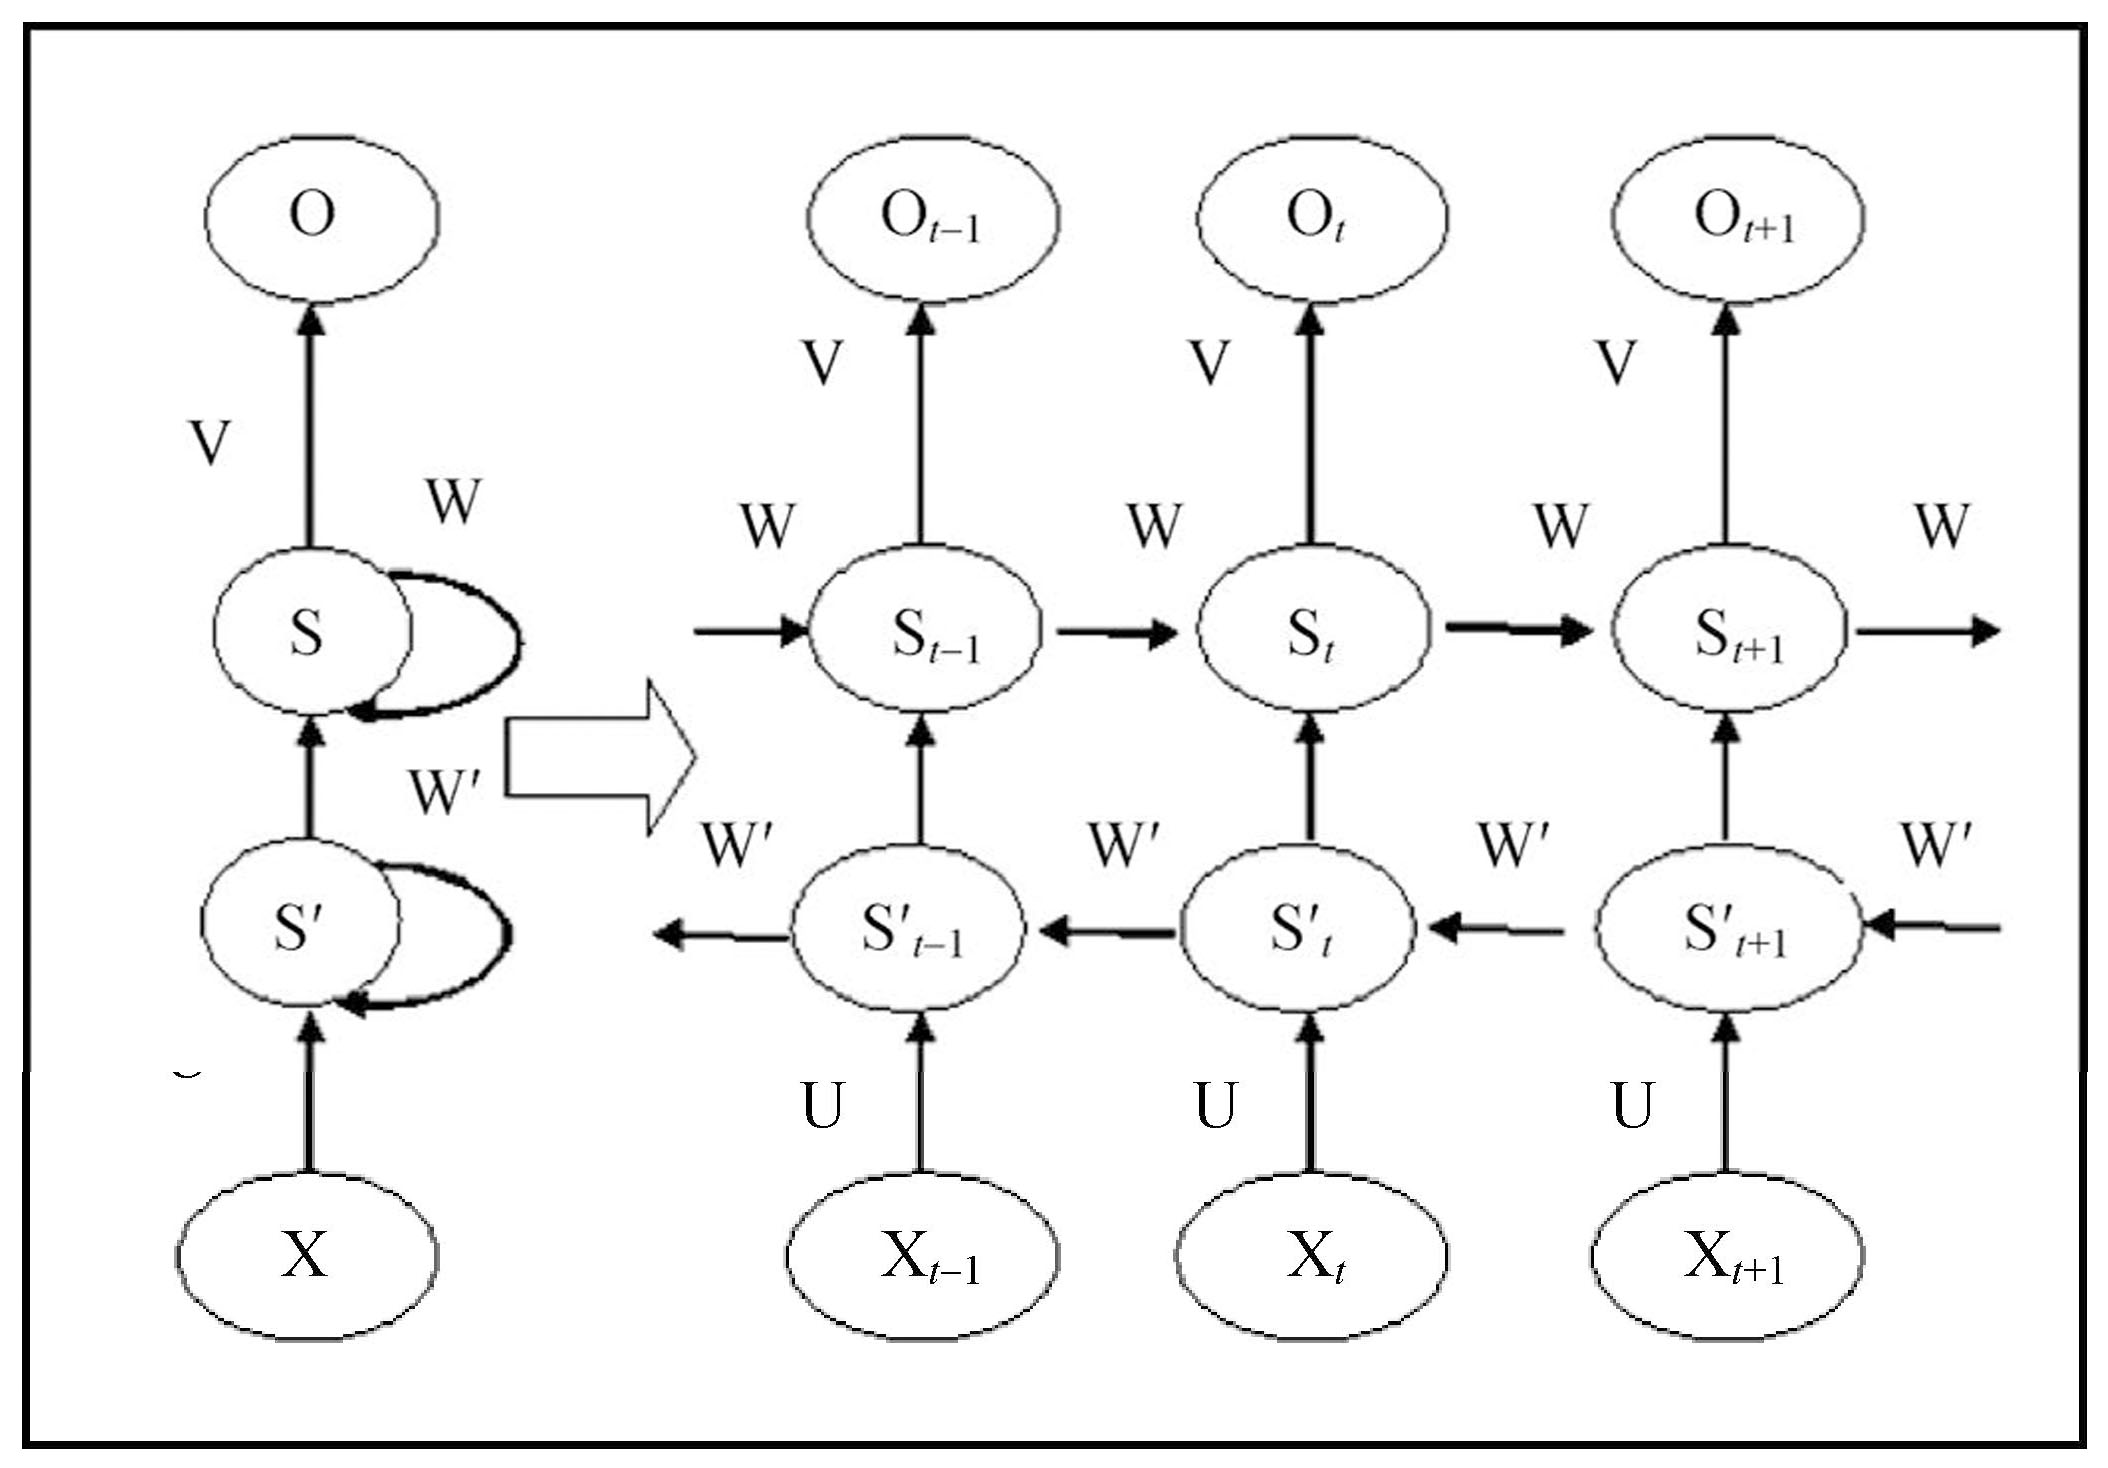

In [ ]:
# 首先导入需要的库。注意，rnn和rnn_cell为TensorFlow库：
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np

In [ ]:
# 网络为MNIST图像做分类，所以需要先载入该数据集：
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

In [ ]:
# 然后定义学习参数：
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

In [ ]:
# 接下来设置网络参数：
n_input = 28
n_steps = 28
n_hidden = 128
n_classes = 10

接着设置占位符，用于馈给我们的网络。首先，为输入图像定义一个占位符变量。这使得我们能够改变输入到TensorFlow图中的图像。数据类型设置为float，张量的形状为[None, n_steps, n_input]。其中，None代表该张量中可以载入任意数量的图像：

In [ ]:
x = tf.placeholder("float", [None, n_steps, n_input])

然后设置第二个占位符，表示输入到占位符变量x中图像的标签。该占位符变量的形状被设置为[None, n_classes]，表示该张量可以载入任意数量的标签，且每个标签为长度为num_classes的向量。此处num_classes取10：

In [ ]:
y = tf.placeholder("float", [None, n_classes])

第一个需要优化的变量是权重weights。此处被定义为一个TensorFlow变量，需要被初始化为平均分布的随机值，且形状为`[2*n_hidden, n_classes]`。

In [ ]:
# 以下是weights的定义：
weights = {
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}

In [ ]:
# 然后定义对应的偏差biases：
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [ ]:
# 使用下面的BiRNN函数，定义weights和网络的biases：
def BiRNN(x, weights, biases):

In [ ]:
# 为实现这一定义，使用以下语句对张量进行变形：
x = tf.transpose(x, [1, 0, 2])
x = tf.reshape(x, [-1, n_input])
x = tf.split(axis=0, num_or_size_splits=n_steps, value=x)

In [ ]:
# 不用考虑前一个模型，此处定义两种类型的LSTM元胞：前向元胞和后向元胞。
lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
lstm_bw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

然后导入`rnn.bidirectional_rnn()` 类构建双向网络。和无向的情况类似，`rnn.bidirectional_rnn()`将最终的前后向输出作为输入，构建深度级联的独立前后向RNN：

In [ ]:
try:
    outputs, _, _ = rnn. static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,dtype=tf.float32)
except Exception:
    outputs = rnn. static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,dtype=tf.float32)

In [ ]:
# 前向和后向元胞的input_size必须一致。注意，其输出必须符合以下格式：
[time][batch][cell_fw.output_size + cell_bw.output_size]

In [ ]:
# BiRNN函数返回一个输出张量，用以确定输入图像属于10个类中的哪一个：
return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [ ]:
# BiRNN函数的返回值接下来会被转入pred张量：
pred = BiRNN(x, weights, biases)

然后计算每个被分类图像的交叉熵值，因为需要对模型在每张图上的表现制定一个评价标准。

如果要用交叉熵指导网络的优化过程，需要单一的标量值。所以，只要简单将所有被分类图像的交叉熵求平均（tf.reduce_mean）即可：

In [ ]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

In [ ]:
# 将得到的误差值用optimizer变量最小化。此处使用AdamOptimizer，这是梯度下降的一种高级形式：
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [ ]:
# 加入评价模型性能的指标，以显示训练过程的进度。这是一个布尔向量，记录模型预测类别是否和图像的真实类别相同：
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))

In [ ]:
# correct_pred变量用于计算分类准确率。
# 首先将布尔变量的类型转换为float，这样false变成了0，true变成了1。
# 然后计算这些数的平均值：
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
# 所有变量在开始优化前都要先初始化：
init = tf.global_variables_initializer()

In [ ]:
# 然后创建session会话，执行计算图：
with tf.Session() as sess:
    sess.run(init)
    step = 1

In [ ]:
# 在会话中，取一批训练样本：
while step * batch_size < training_iters:

In [ ]:
# batch_x变量现在含有训练图像的一个子集，batch_y是这批图像对应的真实标签：
batch_x, batch_y = mnist.train.next_batch(batch_size)
batch_x = batch_x.reshape((batch_size, n_steps, n_input))

In [ ]:
# 将该批集馈给feed_dict，并正确设置占位符变量的名称。然后，使用sees.run运行优化器：
sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
if step % display_step == 0:

In [ ]:
# 计算这些数据集上的准确率和loss值：
acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
print("Iter " + str(step*batch_size) + 
      ", Minibatch Loss= " + "{:.6f}".format(loss) + 
      ", Training Accuracy= " + "{:.5f}".format(acc))
    step += 1
print("Optimization Finished!")

In [ ]:
# 在训练会话的末尾，取一批测试样本：
test_len = 128
test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
test_label = mnist.test.labels[:test_len]

In [ ]:
# 最后，计算并显示测试集上的准确率：
print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

In [ ]:
# 完整代码
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

n_input = 28 
n_steps = 28 
n_hidden = 128 
n_classes = 10 

x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

weights = {
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

def BiRNN(x, weights, biases):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(axis=0, num_or_size_splits=n_steps, value=x)
    lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = BiRNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label}))